# Check the sentence profanity classification



|  hate speech  | offensive language  |  neither |  
|---|---|---| 
| 0  |  1 |  2 |  

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import itertools
import re
import os
import math
import pprint as pp


# Data 

## Download data

In [ ]:
URL = "https://dl.dropbox.com/s/ewpit86gekpiwk5/hate_dirty_peech_labeled_data.tsv"
path = tf.keras.utils.get_file(URL.split('/')[-1], URL)
data = pd.read_csv(path, sep="\t")


2555904/2552512 [==============================] - 0s 0us/step


## Shuffle data

In [ ]:
data = data.sample(frac=1)
data.head()


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
14547,14903,3,0,3,0,1,RT @CHlLDHOODRUINER: 1000 rts and he'll spark ...
22994,23482,6,0,6,0,1,Wowwww this bitch is so ratchet holy crap
19009,19440,3,0,3,0,1,"RT @freckle_juice: if a ""man"" tells you he doe..."
8808,9060,3,0,3,0,1,Don't no nigga want an artificial bitch ... Le...
5796,5968,3,0,3,0,1,@danikawillow don't be a pussy. Also there is ...


## Clean data

In [ ]:
data = data[pd.notnull(data['class'])]
data = data[pd.notnull(data['tweet'])]
data = data.drop(data.columns[0], axis=1) 
data = data.drop(columns=['count', 'hate_speech', 'offensive_language', 'neither']) 
 
data["tweet"] = data["tweet"].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem)) 

data["label"] = data["class"]

# class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither
data['class'].astype(str)
data = data.replace({'class': {0: "hate speech", 1: "offensive language", 2: "neither"}})

# Print the first first five rows as default
data.head(150)


,class,tweet,label
14547,offensive language,RT 1000 rts and hell spark this hoe in here,1
22994,offensive language,Wowwww this bitch is so ratchet holy crap,1
19009,offensive language,RT juice if a man tells you he doesnt eat puss...,1
8808,offensive language,Dont no nigga want an artificial bitch Let me...,1
5796,offensive language,dont be a pussy Also there is beer AND FREE P...,1
...,...,...,...
5631,offensive language,128557128557128557128557128557 how u kno im t...,1
21530,neither,The brownies I just made are a sin,2
8934,hate speech,Elizabeth is astupid hoe,0
21862,offensive language,They hardly get sexso when the opportunity of ...,1


# Create texts and labels

## Create labels

In [ ]:
labels = data["label"].to_list()
print(labels[:10])


[1, 1, 1, 1, 1, 2, 1, 1, 1, 1]


In [ ]:
label_count = len(set(labels))
print(label_count)


3


### Create texts sequences

In [ ]:
texts = data["tweet"].to_numpy()
type(texts)
print(texts[:10])


['RT  1000 rts and hell spark this hoe in here '
 'Wowwww this bitch is so ratchet holy crap'
 'RT juice if a man tells you he doesnt eat pussy ampexpects to have sex just laugh laugh as u put your clothes on laugh as u g8230'
 'Dont no nigga want an artificial bitch  Let me repeat that Not one '
 ' dont be a pussy Also there is beer AND FREE PIZZA HERE I SWEAR'
 'Amo hangs '
 'twotone Next year bitches is gonna be like you gotta promise you wont expose me 128514128514128557'
 'RT  bitch built like squid ward after he ate all the Krabby Patties RT   DONT RETIRE 128553 I love you h8230'
 'RT JSmart24 Twitter was fye when niggas used to go in on Trending Topics8230now its just recycled tweets and hoes screaming they want loy8230'
 'RT  Lol that same bitch I was cool with was was down to sit me up in get me kill in get on twitter in talk about it']


In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(texts)


In [ ]:
word_index = tokenizer.word_index
total_words = len(word_index) + 1
print(total_words) 


27426


In [ ]:
sequences = tokenizer.texts_to_sequences(texts)
total_sequences = len(sequences)
print(total_sequences)
print(sequences[:10])


24776
[[3, 2568, 3446, 8, 269, 4634, 20, 25, 11, 126], [10654, 20, 2, 13, 37, 585, 1105, 2210], [3, 1305, 32, 1, 91, 1427, 6, 60, 320, 167, 22, 10655, 7, 56, 338, 33, 822, 822, 74, 43, 185, 29, 793, 17, 822, 74, 43, 3932], [27, 41, 46, 82, 103, 10656, 2, 132, 15, 3933, 10, 47, 71], [27, 18, 1, 22, 519, 143, 13, 907, 8, 339, 1373, 126, 4, 295], [5673, 7281], [10657, 240, 293, 12, 13, 153, 18, 14, 6, 145, 2043, 6, 263, 3934, 15, 7282], [3, 2, 1492, 14, 5674, 7283, 214, 60, 674, 31, 5, 7284, 10658, 3, 27, 7285, 690, 4, 72, 6, 1566], [3, 3935, 181, 49, 10659, 39, 67, 452, 7, 79, 11, 17, 3447, 10660, 58, 33, 10661, 438, 8, 19, 1633, 38, 82, 10662], [3, 57, 10, 196, 2, 4, 49, 395, 26, 49, 49, 133, 7, 513, 15, 30, 11, 35, 15, 306, 11, 35, 17, 181, 11, 144, 59, 24]]


#### 🍼Define max length 

In [ ]:
max_len = max([len(s) for s in sequences])
print(max_len)
max_len =  int(max_len / 3.6)
print(max_len)


57
15


### Shift each sequence to generate more "texts"

In [ ]:
def shift_sequences(unshifted_sequences, labels):
  shifted = []
  i = -1
  for seq in unshifted_sequences:
    i = i + 1
    length = len(seq)
    shifted.append((seq, labels[i]))
    if length > 3: [shifted.append((seq[:-shift], labels[i])) for shift in range(1, length-1)]  
  return shifted


In [ ]:
shifted_sequences_labels = np.array(shift_sequences(sequences, labels))

sequences = shifted_sequences_labels[:,:-1][:,0]
print(sequences[:3])

labels = shifted_sequences_labels[:,-1]
print(labels[:3])

total_sequences = len(sequences)
print(total_sequences)

[list([3, 2568, 3446, 8, 269, 4634, 20, 25, 11, 126])
 list([3, 2568, 3446, 8, 269, 4634, 20, 25, 11])
 list([3, 2568, 3446, 8, 269, 4634, 20, 25])]
[1 1 1]
304862


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    sequences,
    padding = "post",
    maxlen = max_len
)

#padded_sequences = tf.expand_dims(padded_sequences, axis=-1)
print(type(padded_sequences))
print(padded_sequences[:5])

labels = np.asarray(labels).astype(np.int)
print(labels[:5])

<class 'numpy.ndarray'>
[[   3 2568 3446    8  269 4634   20   25   11  126    0    0    0    0
     0]
 [   3 2568 3446    8  269 4634   20   25   11    0    0    0    0    0
     0]
 [   3 2568 3446    8  269 4634   20   25    0    0    0    0    0    0
     0]
 [   3 2568 3446    8  269 4634   20    0    0    0    0    0    0    0
     0]
 [   3 2568 3446    8  269 4634    0    0    0    0    0    0    0    0
     0]]
[1 1 1 1 1]


## Divide training data and testing data

### Training data

In [ ]:
boundary = int(.85 * total_sequences)

training_sequences = padded_sequences[:boundary]
training_labels = labels[:boundary]

print(len(training_sequences))
print(len(training_labels))

print(training_sequences[:5])
print(training_labels[:5])


259132
259132
[[   3 2568 3446    8  269 4634   20   25   11  126    0    0    0    0
     0]
 [   3 2568 3446    8  269 4634   20   25   11    0    0    0    0    0
     0]
 [   3 2568 3446    8  269 4634   20   25    0    0    0    0    0    0
     0]
 [   3 2568 3446    8  269 4634   20    0    0    0    0    0    0    0
     0]
 [   3 2568 3446    8  269 4634    0    0    0    0    0    0    0    0
     0]]
[1 1 1 1 1]


### Testing data

In [ ]:
testing_sequences = padded_sequences[boundary:]
testing_labels = labels[boundary:]

total_testing_sequences = len(testing_sequences)
print(total_testing_sequences)
print(len(testing_labels))

print(testing_sequences[:5])
print(testing_labels[:5])


45730
45730
[[24911    97   154    63  3666    34    23    55   126   415    63  4953
     26    41     2]
 [  444 24911    97   154    63  3666    34    23    55   126   415    63
   4953    26    41]
 [ 6427   444 24911    97   154    63  3666    34    23    55   126   415
     63  4953    26]
 [  177  6427   444 24911    97   154    63  3666    34    23    55   126
    415    63  4953]
 [  176   177  6427   444 24911    97   154    63  3666    34    23    55
    126   415    63]]
[1 1 1 1 1]


# Machine-learning

## Hyperparameters

In [ ]:
epochs = 100
embedding_dim = 512


## Utils, like output, graphic etc....

### Table of *prediction*

In [ ]:
import matplotlib.pyplot as plt

def predict_output(texts, predicated_classes):
    fig, ax = plt.subplots()
    ax.axis('off')

    predicated_classes = np.expand_dims(predicated_classes, axis=-1)

    table = ax.table(
             rowLabels=texts,  
             colLabels=["classification"],  
             cellText=predicated_classes, 
             cellLoc="center", 
             loc="center"
    )
    table.scale(0.5, 1)  
    
    ax.set_title('0: "hate speech", 1: "offensive language", 2: "neither"',
              fontweight ="bold")

    fig.tight_layout()
    plt.show()

### 📊Grpahic of training

In [ ]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

def plot(history, m0, m1): 
  h_m0=history.history[m0] 
  h_m1=history.history[m1] 
  epochs=range(len(h_m0))  
  plt.plot(epochs, h_m0, 'b', m0) 
  plt.figure()  
  plt.plot(epochs, h_m1, 'b', m1)  

## Methods

### 🎉Method of building model

In [ ]:
def build_model(*layers):
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Embedding(
            input_dim=total_words,
            output_dim=embedding_dim,
            input_shape=[None,]
        ),
    ) 
    [model.add(layer) for layer in layers]

    model.add(tf.keras.layers.Dense(int(total_words),
                                    activation=tf.keras.activations.relu))
    model.add(tf.keras.layers.Dropout(.5))
    model.add(tf.keras.layers.Dense(label_count, activation=tf.keras.activations.softmax))
 
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"],
    )
    model.summary()

    return model

In [ ]:
earlyStop = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3)

### 🏋️‍♀️Method of traning 

In [ ]:
def train_model(model):
    tf.keras.backend.clear_session()
    tf.random.set_seed(51)
    np.random.seed(51)

    return model.fit(
              x=training_sequences, 
              y=training_labels, 
              #validation_split
              #validation_data=(valid_sequences, valid_labels)
              #wont make sense see: https://stackoverflow.com/a/57391324/1835650
              verbose=1,
              epochs=epochs,
              callbacks=[earlyStop])

### Method of prediction

In [ ]:
def predict(model, texts):
    tokenizer.fit_on_texts(texts)
    tokenized_texts = tokenizer.texts_to_sequences(texts)
    padded_texts = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_texts,
        maxlen = max_len,
        padding = "post", 
    )
    predicted = model.predict(padded_texts)
    predicted_classes = np.argmax(predicted, axis=-1)

    print("texts: {}".format(texts))
    print("tokenized_texts: {}".format(tokenized_texts))
    print("padded_texts: {}".format(padded_texts))
    print("predicted: {}".format(predicted))
    print("predicted class: {}".format(predicted_classes))
    predict_output(texts, predicted_classes)

### Method of evaluation

In [ ]:
def evaluate_model(model):
  print("Evaluate on test data")
  results = model.evaluate(testing_sequences, testing_labels) 

## Try model without training

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 512)         14042112  
_________________________________________________________________
global_average_pooling1d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 27426)             14069538  
_________________________________________________________________
dropout (Dropout)            (None, 27426)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 82281     
Total params: 28,193,931
Trainable params: 28,193,931
Non-trainable params: 0
_________________________________________________________________
texts: ['hello', 'bad man', 'fuck you', 'suck you', 'you bitch']
tokenized_texts: [[1573], [84, 91], [36, 6], 

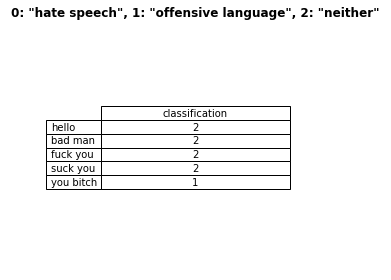

In [ ]:
model = build_model(tf.keras.layers.GlobalAveragePooling1D())
predict(model, ["hello", "bad man", "fuck you", "suck you", "you bitch"])

## 💥Training

In [26]:
model = build_model( 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=32)),
)
history = train_model(model)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 512)         14042112  
_________________________________________________________________
bidirectional (Bidirectional (None, None, 256)         656384    
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         164352    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 27426)             1782690   
_________________________________________________________________
dropout_1 (Dropout)          (None, 27426)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

## Training completed

### Result

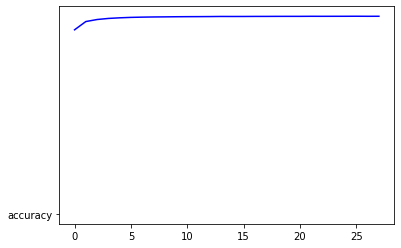

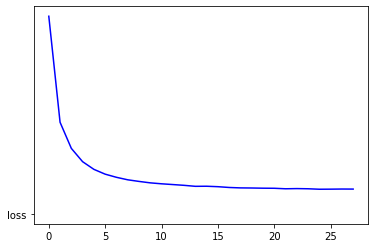

In [27]:
plot(history, "accuracy", "loss")


### Try to predict

texts: ['some friends tell me how it is']
tokenized_texts: [[61, 286, 141, 15, 69, 24, 13]]
padded_texts: [[ 61 286 141  15  69  24  13   0   0   0   0   0   0   0   0]]
predicted: [[2.2181692e-09 2.0328334e-05 9.9997962e-01]]
predicted class: [2]


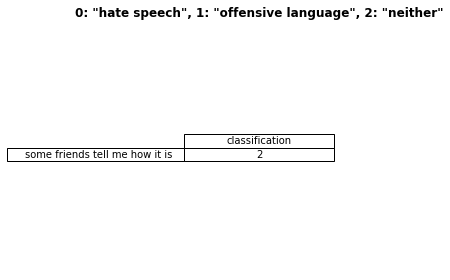

In [33]:
predict(model, ["some friends tell me how it is"])


### Evaluation

In [29]:
evaluate_model(model)

Evaluate on test data
1430/1430 [==============================] - 11s 6ms/step - loss: 3.2735 - accuracy: 0.7647
